In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_utils 
import mnist_vae_lib
import vae_training_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
data_dir = './mnist_data/'
propn_sample = 0.01

In [3]:
train_set, test_set = mnist_data_utils.get_moving_mnist_dataset(data_dir, propn_sample)

In [9]:
batchsize = 10

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [10]:
len(train_loader.dataset)

600

In [11]:
for batch_idx, d in enumerate(train_loader):
    data_train = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [12]:
slen = data_train['image'].shape[-1]

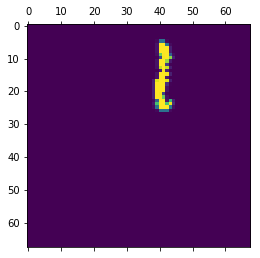

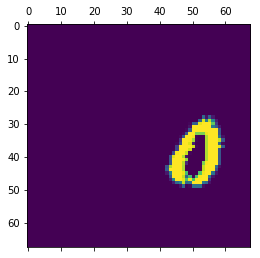

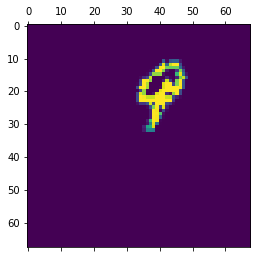

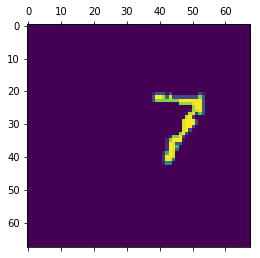

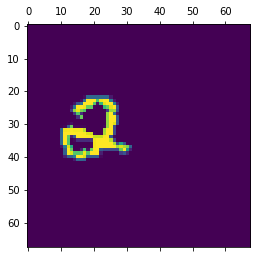

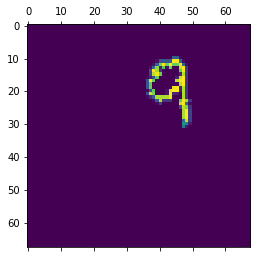

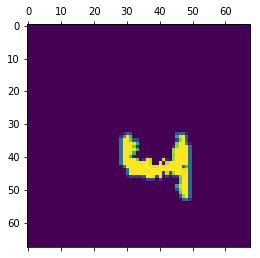

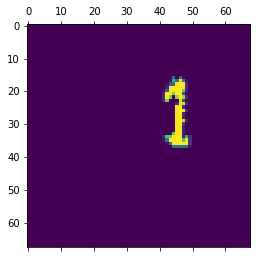

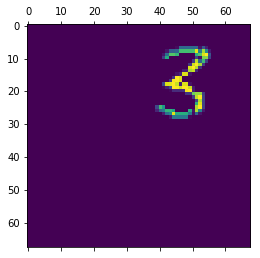

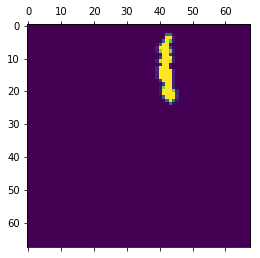

In [13]:
for i in range(batchsize): 
    plt.matshow(data_train['image'][i, 0, :, :])

In [14]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

# Define VAE

In [15]:
moving_mnist_vae = mnist_vae_lib.MovingHandwritingVAE()

In [16]:
vae_file = './mnist_vae_results/moving_mnist_vae_topk5_final'
# vae_file = './mnist_vae_results/moving_mnist_vae_nsamples6_epoch80'

moving_mnist_vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

moving_mnist_vae.eval()

MovingHandwritingVAE(
  (mnist_vae): HandwritingVAE(
    (encoder): MLPEncoder(
      (fc1): Linear(in_features=841, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=10, bias=True)
      (tanh): Tanh()
    )
    (decoder): MLPDecoder(
      (fc1): Linear(in_features=5, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=841, bias=True)
      (sigmoid): Sigmoid()
      (tanh): Tanh()
    )
  )
  (pixel_attention): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
    )
    (fc1): Linear(in_features=3600, out_features=4624, bias=True)
    (log_softmax): LogSoftmax()
  )
)

In [17]:
train_loss = vae_training_lib.eval_vae(moving_mnist_vae, train_loader, train = False,
                            set_true_loc = False)

print(train_loss)

tensor(165.6402)


(array([2., 1., 0., 1., 2., 0., 1., 1., 0., 2.]),
 array([ 71.48311615,  88.28708878, 105.0910614 , 121.89503403,
        138.69900665, 155.50297928, 172.3069519 , 189.11092453,
        205.91489716, 222.71886978, 239.52284241]),
 <a list of 10 Patch objects>)

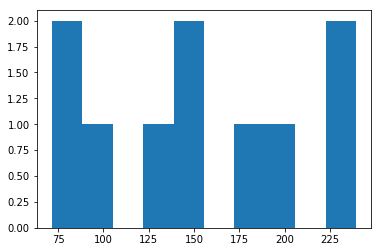

In [18]:
plt.hist(moving_mnist_vae.get_rb_loss(image, n_samples = 0)[1].detach())

In [19]:
moving_mnist_vae.get_rb_loss(image, n_samples = 0)[1]

tensor([  78.4878,  177.0280,  150.4141,  114.6340,  235.1031,  141.5978,
         232.2986,  105.1709,  194.8699,   73.4130])

In [20]:
moving_mnist_vae.get_rb_loss(image[0:5], n_samples = 0)[1]

tensor([  83.6385,  178.3261,  151.0336,  116.6914,  239.8786])

In [16]:
foo1 = moving_mnist_vae.pixel_attention(image)[0:5]

In [17]:
foo2 = moving_mnist_vae.pixel_attention(image[0:5])

In [18]:
np.all((foo1 - foo2) == 0)

True

In [21]:
images_debugging = np.load('./mnist_vae_results/moving_mnist_vae_topk5images_debugging.npy')
images_debugging = torch.Tensor(images_debugging)

In [22]:
moving_mnist_vae.get_rb_loss(images_debugging, n_samples = 0)[1].mean()

tensor(169.8271)

In [23]:
moving_mnist_vae.get_rb_loss(images_debugging[0:30], n_samples = 0)[1].mean()

tensor(169.2824)

In [24]:
moving_mnist_vae.get_rb_loss(images_debugging[30:64], n_samples = 0)[1].mean()

tensor(167.3000)

In [25]:
moving_mnist_vae.get_rb_loss(images_debugging, n_samples = 0)[1].detach()

tensor([ 145.2836,  104.4310,  125.8887,  140.7928,  150.7034,  209.9304,
         180.5640,   71.4232,  195.0587,  227.2199,   68.3074,  161.3999,
         175.2012,  199.5052,  283.1350,  174.0150,  220.0707,  215.3524,
         164.1958,  199.8307,  179.5627,  114.3720,  167.5226,  176.8219,
         171.9687,  174.2028,  111.0246,  193.3221,  155.3155,  251.6628,
         130.1214,  177.6380,   75.1955,   92.2692,  193.2436,  166.8870,
         168.6073,  134.3555,  246.8910,  170.3630,  185.3788,  173.0126,
          97.1221,  236.5477,  174.5313,  135.7855,  153.4771,  174.0191,
          64.8447,  106.4713,  157.8985,  200.0132,  209.8404,  114.0328,
          59.3268,  181.8717,  184.4349,  109.3857,  219.4193,  199.4371,
         288.9881,  281.4748,  192.1569,  234.9953])

In [65]:
moving_mnist_vae.get_rb_loss(images_debugging[0:1], n_samples = 0)

(0.0, tensor([ 127.8327]))

(array([ 5.,  3.,  5.,  8., 13., 14.,  7.,  5.,  1.,  3.]),
 array([-96.93418884, -73.82709656, -50.72000427, -27.61291199,
         -4.5058197 ,  18.60127258,  41.70836487,  64.81545715,
         87.92254944, 111.02964172, 134.13673401]),
 <a list of 10 Patch objects>)

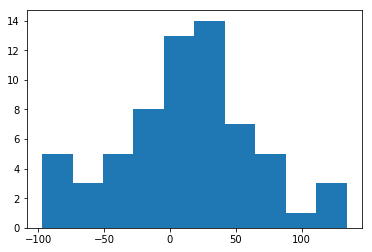

In [40]:
plt.hist(moving_mnist_vae.get_rb_loss(images_debugging, n_samples = 0)[1].detach())

In [15]:
image = data_train['image']
pixel_2d = data_train['pixel_2d']

In [72]:
log_pixel_probs = moving_mnist_vae.pixel_attention(image)

In [48]:
map_pixel_1d = torch.argmax(log_pixel_probs, dim=1)

In [49]:
use_true_loc = False
if use_true_loc: 
    map_pixel_1d = moving_mnist_vae._pixel_1d_from_2d(pixel_2d)
recon_means = moving_mnist_vae.forward_cond_pixel_1d(data_train['image'], map_pixel_1d)[0]

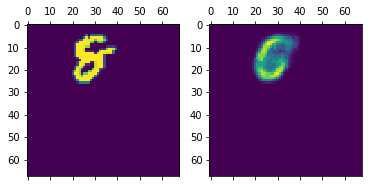

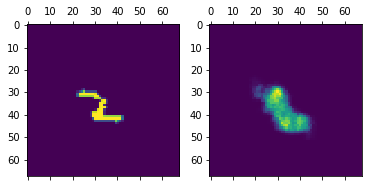

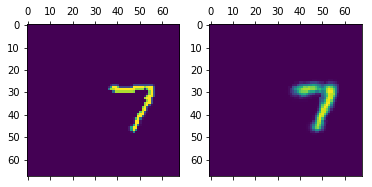

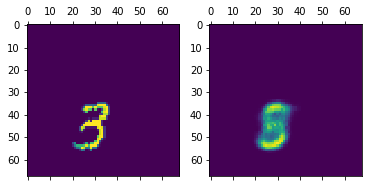

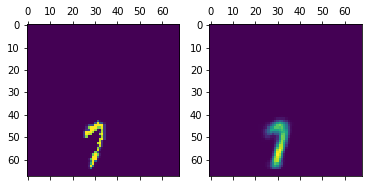

In [50]:
# Check reconstructions 

for i in range(0, 5): 
    
    _, axarr = plt.subplots(1, 2, figsize=(6, 6))
    
    axarr[0].matshow(data_train['image'][i, 0, :, :])
    axarr[1].matshow(recon_means[i, 0, :, :].detach())

In [18]:
# batch_losses = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_batch_losses.npy')

In [19]:
batch_losses_rb = np.load('./mnist_vae_results/moving_mnist_vae_topk5_batch_losses.npy')

In [20]:
batch_losses_resample = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_batch_losses.npy')

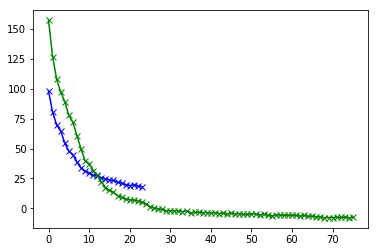

In [21]:
# plt.plot(batch_losses, 'r-x'); 
plt.plot(batch_losses_rb[4:-1], 'b-x'); 
plt.plot(batch_losses_resample[4:-1], 'g-x');

In [38]:
test_losses = np.load('./mnist_vae_results/moving_mnist_vae_nsamples6_test_losses.npy')

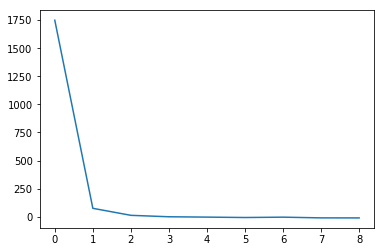

In [39]:
plt.plot(test_losses)